In [1]:

# Importy bibliotek
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Sprawdzenie wersji TensorFlow (opcjonalne, ale przydatne)
print(f"Wersja TensorFlow: {tf.__version__}")

Wersja TensorFlow: 2.20.0


In [2]:
# Załadowanie zestawu danych MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalizacja danych: skalowanie wartości pikseli z [0, 255] do [0.0, 1.0]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Zmiana kształtu danych dla sieci CNN (dodanie wymiaru kanału: (28, 28) -> (28, 28, 1))
x_train = x_train[..., tf.newaxis].astype(np.float32)
x_test = x_test[..., tf.newaxis].astype(np.float32)

# Konwersja etykiet na format one-hot encoding (np. 5 -> [0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print(f"Kształt danych treningowych (obrazy): {x_train.shape}")
print(f"Kształt danych treningowych (etykiety): {y_train.shape}")

Kształt danych treningowych (obrazy): (60000, 28, 28, 1)
Kształt danych treningowych (etykiety): (60000, 10)


In [3]:
# Funkcja do tworzenia prostego modelu CNN
def create_cnn_model():
    model = tf.keras.Sequential([
        # Warstwa konwolucyjna: 32 filtry 3x3, ReLU, oczekiwany kształt wejściowy (28, 28, 1)
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        # Warstwa Max Pooling: redukcja wymiarów 2x2
        tf.keras.layers.MaxPooling2D((2, 2)),
        # Druga warstwa konwolucyjna: 64 filtry 3x3, ReLU
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        # Druga warstwa Max Pooling
        tf.keras.layers.MaxPooling2D((2, 2)),
        # Spłaszczenie danych do jednowymiarowego wektora
        tf.keras.layers.Flatten(),
        # Warstwa gęsta (fully connected): 128 jednostek, ReLU
        tf.keras.layers.Dense(128, activation='relu'),
        # Warstwa wyjściowa: 10 jednostek (klas), Softmax (dystrybucja prawdopodobieństwa)
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    # Kompilacja modelu: optymalizator Adam, funkcja straty Cross-Entropy dla klasyfikacji
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Stworzenie i wytrenowanie początkowego modelu
print("Rozpoczęcie treningu modelu bazowego...")
model = create_cnn_model()
history = model.fit(x_train, y_train, epochs=3, validation_split=0.1, batch_size=64, verbose=1)

print("\n Trening modelu bazowego zakończony.")

Rozpoczęcie treningu modelu bazowego...
Epoch 1/3


C:\Users\Damian\Documents\GitHub\Engieering Thesis\Adversarial_Attacks\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.9491 - loss: 0.1705 - val_accuracy: 0.9843 - val_loss: 0.0554
Epoch 2/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9834 - loss: 0.0519 - val_accuracy: 0.9878 - val_loss: 0.0388
Epoch 3/3
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9889 - loss: 0.0358 - val_accuracy: 0.9890 - val_loss: 0.0396

 Trening modelu bazowego zakończony.


In [4]:
#Ocena Modelu Bazowego

# Ocena modelu na czystym (niezaatakowanym) zbiorze testowym
print("Ocena modelu bazowego na czystym zbiorze testowym:")
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Strata (Loss): {loss:.4f}, Dokładność (Accuracy): {accuracy:.4f}")

Ocena modelu bazowego na czystym zbiorze testowym:
Strata (Loss): 0.0324, Dokładność (Accuracy): 0.9896


In [11]:
#Implementacja Ataku FGSM

# Funkcja do generowania wzorca adwersarialnego (Signed Gradient)
@tf.function
def create_adversarial_pattern(input_image, input_label):
    """
    Oblicza znak gradientu funkcji straty względem obrazu wejściowego.
    """
    loss_object = tf.keras.losses.CategoricalCrossentropy()
    with tf.GradientTape() as tape:
        # Rejestrowanie operacji na obrazie, aby móc obliczyć gradient
        tape.watch(input_image)
        # Przewidywanie modelu
        prediction = model(input_image)
        # Obliczenie straty
        loss = loss_object(input_label, prediction)

    # Obliczenie gradientu straty względem obrazu wejściowego
    gradient = tape.gradient(loss, input_image)
    # Wyodrębnienie znaku z każdego elementu gradientu
    signed_grad = tf.sign(gradient)
    return signed_grad

# Funkcja do tworzenia zbioru adwersarialnych przykładów
def augment_with_adversarial_examples(model, x_data, y_data, epsilon=0.5):
    """
    Generuje przykłady adwersarialne(zwodnicze) na podstawie zbioru danych x_data i y_data,
    używając epsilon jako wskaźnika siły ataku.
    """
    x_data_adv = []

    # Iteracja po wszystkich przykładach w zbiorze danych
    for i in range(len(x_data)):
        image = x_data[i]
        label = y_data[i]

        # Konwersja obrazu i etykiety na tensory z wymiarem wsadowym (batch dim)
        image_tensor = tf.convert_to_tensor(image.reshape((1, 28, 28, 1)), dtype=tf.float32)
        label_tensor = tf.convert_to_tensor(label.reshape((1, 10)), dtype=tf.float32)

        # Obliczenie perturbacji FGSM
        perturbations = create_adversarial_pattern(image_tensor, label_tensor)

        # Stworzenie obrazu adwersarialnego: obraz + epsilon * perturbacja
        adversarial_image = image_tensor + epsilon * perturbations

        # Przycięcie wartości pikseli do prawidłowego zakresu [0, 1]
        adversarial_image = tf.clip_by_value(adversarial_image, 0, 1)

        # Dodanie obrazu do listy (usunięcie wymiaru wsadowego)
        x_data_adv.append(adversarial_image.numpy().squeeze(0))

    return np.array(x_data_adv)

# Definicja siły ataku
epsilon_fgsm = 0.5

print(f"Generowanie adwersarialnych przykładów treningowych z epsilon={epsilon_fgsm}...")
# Generowanie adwersarialnych przykładów dla zbioru treningowego
x_train_adv = augment_with_adversarial_examples(model, x_train, y_train, epsilon=epsilon_fgsm)

print(f"Kształt adwersarialnych danych treningowych: {x_train_adv.shape}")

Generowanie adwersarialnych przykładów treningowych z epsilon=0.2...


KeyboardInterrupt: 

In [6]:
#Trening Adwersarialny

# Połączenie czystych i adwersarialnych danych treningowych
x_train_combined = np.vstack([x_train, x_train_adv])
y_train_combined = np.vstack([y_train, y_train])

print(f"Łączny kształt treningowy (czyste + adwersarialne): {x_train_combined.shape}")

# Retrening nowego modelu na rozszerzonym zbiorze danych
print("\nRozpoczęcie TRENINGU ADWERSARIALNEGO...")
model_adv = create_cnn_model()
history_adv = model_adv.fit(x_train_combined, y_train_combined, epochs=3, validation_split=0.1, batch_size=64, verbose=1)

print("\n Trening Adwersarialny zakończony.")

Łączny kształt treningowy (czyste + adwersarialne): (120000, 28, 28, 1)

Rozpoczęcie TRENINGU ADWERSARIALNEGO...
Epoch 1/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9327 - loss: 0.2199 - val_accuracy: 0.9729 - val_loss: 0.0936
Epoch 2/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9833 - loss: 0.0535 - val_accuracy: 0.9893 - val_loss: 0.0344
Epoch 3/3
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9899 - loss: 0.0323 - val_accuracy: 0.9909 - val_loss: 0.0288

 Trening Adwersarialny zakończony.


In [7]:
#Ocena Odporności Modelu Po Treningu Adwersarialnym

# 1. Ocena na czystym zbiorze testowym
print("\n### 1. Ocena na CZYSTYCH DANYCH TESTOWYCH ###")
loss_clean_adv, acc_clean_adv = model_adv.evaluate(x_test, y_test, verbose=0)
print(f"Strata: {loss_clean_adv:.4f}, Dokładność: {acc_clean_adv:.4f}")

# 2. Generowanie adwersarialnych przykładów dla zbioru testowego (przy użyciu NOWEGO modelu)
print(f"\nGenerowanie adwersarialnych przykładów testowych z epsilon={epsilon_fgsm} dla modelu_adv...")
x_test_adv = augment_with_adversarial_examples(model_adv, x_test, y_test, epsilon=epsilon_fgsm)

# 3. Ocena na adwersarialnym zbiorze testowym
print("\n### 2. Ocena na ADWERSARIALNYCH DANYCH TESTOWYCH (bez obrony) ###")
loss_adv_adv, acc_adv_adv = model_adv.evaluate(x_test_adv, y_test, verbose=0)
print(f"Strata: {loss_adv_adv:.4f}, Dokładność: {acc_adv_adv:.4f}")

print("\nPorównaj te wyniki z wynikami modelu bazowego na tych samych atakach (dokładność modelu_adv powinna być wyższa).")


### 1. Ocena na CZYSTYCH DANYCH TESTOWYCH ###
Strata: 0.0404, Dokładność: 0.9867

Generowanie adwersarialnych przykładów testowych z epsilon=0.5 dla modelu_adv...

### 2. Ocena na ADWERSARIALNYCH DANYCH TESTOWYCH (bez obrony) ###
Strata: 0.0313, Dokładność: 0.9901

Porównaj te wyniki z wynikami modelu bazowego na tych samych atakach (dokładność modelu_adv powinna być wyższa).



### 3. Ocena na PRZETWORZONYCH (Przyciętych) ADWERSARIALNYCH DANYCH TESTOWYCH ###
Strata: 0.0313, Dokładność: 0.9901
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


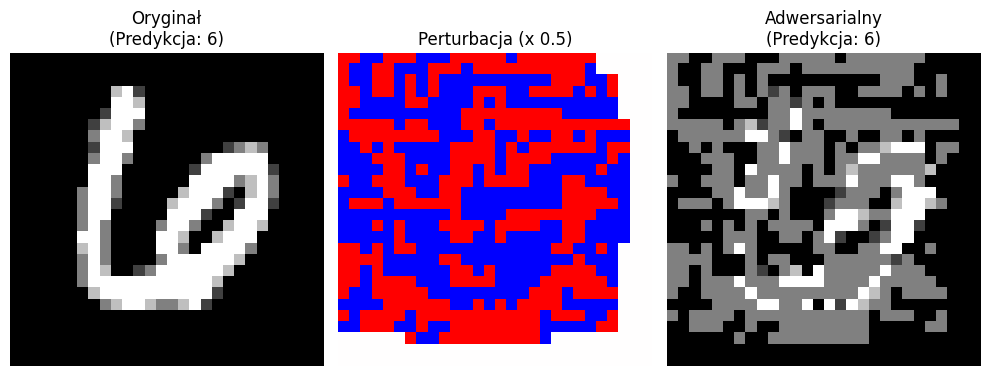

In [8]:
#Dodatkowa Obrona: Przycinanie Wartości Wejściowych (Input Preprocessing Defense - Clipping)

# Przycięcie (clipping) wartości pikseli w adwersarialnych przykładach do zakresu [0, 1]
# Chociaż FGSM już to robi, jest to standardowa prosta technika obronna.
x_test_adv_clipped = np.clip(x_test_adv, 0.0, 1.0)

# Ocena modelu po treningu adwersarialnym na przyciętych adwersarialnych danych testowych
print("\n### 3. Ocena na PRZETWORZONYCH (Przyciętych) ADWERSARIALNYCH DANYCH TESTOWYCH ###")
loss_clip_adv, acc_clip_adv = model_adv.evaluate(x_test_adv_clipped, y_test, verbose=0)
print(f"Strata: {loss_clip_adv:.4f}, Dokładność: {acc_clip_adv:.4f}")

# Wizualizacja (Opcjonalne)
def display_adversarial_image(original, adversarial, prediction_orig, prediction_adv, perturbation):
    plt.figure(figsize=(10, 4))

    # Oryginalny obraz
    plt.subplot(1, 3, 1)
    plt.title(f"Oryginał\n(Predykcja: {np.argmax(prediction_orig)})")
    plt.imshow(original.squeeze(), cmap='gray')
    plt.axis('off')

    # Perturbacja
    plt.subplot(1, 3, 2)
    plt.title("Perturbacja (x " + str(epsilon_fgsm) + ")")
    # Skalowanie kolorów perturbacji
    plt.imshow(perturbation.numpy().squeeze(), cmap='bwr', vmin=-1, vmax=1)
    plt.axis('off')

    # Obraz adwersarialny
    plt.subplot(1, 3, 3)
    plt.title(f"Adwersarialny\n(Predykcja: {np.argmax(prediction_adv)})")
    plt.imshow(adversarial.squeeze(), cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Wybór losowego przykładu do wizualizacji
idx = np.random.randint(0, len(x_test_adv))
orig_image = x_test[idx]
adv_image = x_test_adv[idx]
label = y_test[idx]

# Generowanie perturbacji dla wizualizacji
image_tensor = tf.convert_to_tensor(orig_image.reshape((1, 28, 28, 1)), dtype=tf.float32)
label_tensor = tf.convert_to_tensor(label.reshape((1, 10)), dtype=tf.float32)
perturbation = create_adversarial_pattern(image_tensor, label_tensor)

# Przewidywanie modelu_adv
pred_orig = model_adv.predict(orig_image[tf.newaxis, ...])
pred_adv = model_adv.predict(adv_image[tf.newaxis, ...])

display_adversarial_image(orig_image, adv_image, pred_orig, pred_adv, perturbation)

Generowanie adwersarialnych przykładów testowych dla modelu bazowego...
Dokładność modelu bazowego na ataku: 0.0189


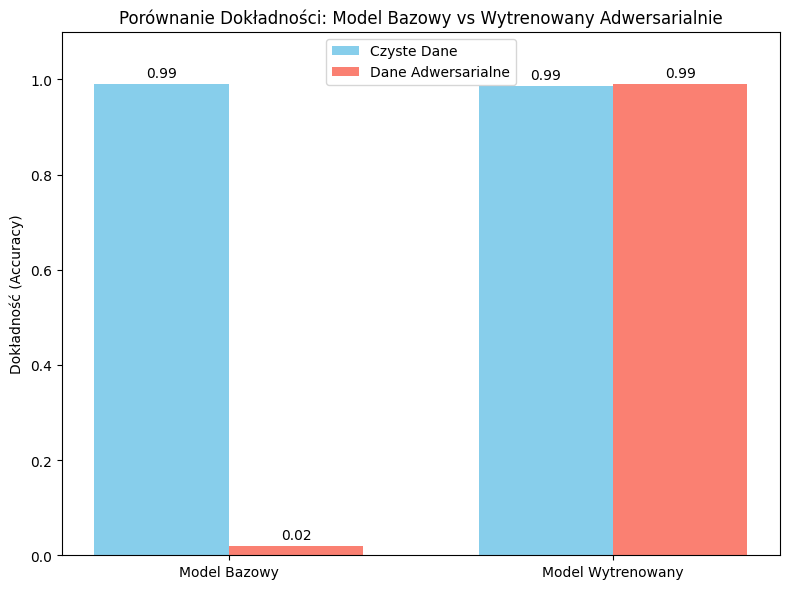

In [9]:
# === PORÓWNANIE MODELI (WIZUALIZACJA) ===

# 1. Obliczenie dokładności modelu bazowego na danych adwersarialnych
# Musimy wygenerować przykłady adwersarialne DLA MODELU BAZOWEGO (jeśli jeszcze tego nie zrobiliśmy dla testu)
# Wcześniej generowaliśmy x_train_adv, teraz potrzebujemy x_test_adv_base
print("Generowanie adwersarialnych przykładów testowych dla modelu bazowego...")
x_test_adv_base = augment_with_adversarial_examples(model, x_test, y_test, epsilon=epsilon_fgsm)
loss_base_adv, acc_base_adv = model.evaluate(x_test_adv_base, y_test, verbose=0)
print(f"Dokładność modelu bazowego na ataku: {acc_base_adv:.4f}")

# 2. Przygotowanie danych do wykresu
models_labels = ['Model Bazowy', 'Model Wytrenowany']
clean_accuracies = [accuracy, acc_clean_adv]  # accuracy z cella 3, acc_clean_adv z cella 6
adv_accuracies = [acc_base_adv, acc_adv_adv]  # acc_base_adv obliczone wyżej, acc_adv_adv z cella 6

# 3. Rysowanie wykresu słupkowego
x = np.arange(len(models_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, clean_accuracies, width, label='Czyste Dane', color='skyblue')
rects2 = ax.bar(x + width/2, adv_accuracies, width, label='Dane Adwersarialne', color='salmon')

# Dodanie etykiet, tytułu i legendy
ax.set_ylabel('Dokładność (Accuracy)')
ax.set_title('Porównanie Dokładności: Model Bazowy vs Wytrenowany Adwersarialnie')
ax.set_xticks(x)
ax.set_xticklabels(models_labels)
ax.set_ylim(0, 1.1) # Skala do 1.1 dla czytelności etykiet
ax.legend()

# Funkcja do wyświetlania wartości nad słupkami
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


=== ANALIZA ADVERSARIALNA POJEDYNCZEJ PRÓBKI ===
Indeks obrazu: 4
Prawdziwa klasa: 4
Epsilon: 0.2

MODEL BAZOWY      : przed treningiem adversarialnym
MODEL WYRENOWANY  : po treningu adversarialnym

[1] Generowanie ataku FGSM na MODEL BAZOWY (przed treningiem adversarialnym)
[2] Generowanie ataku FGSM na MODEL WYRENOWANY (po treningu adversarialnym)


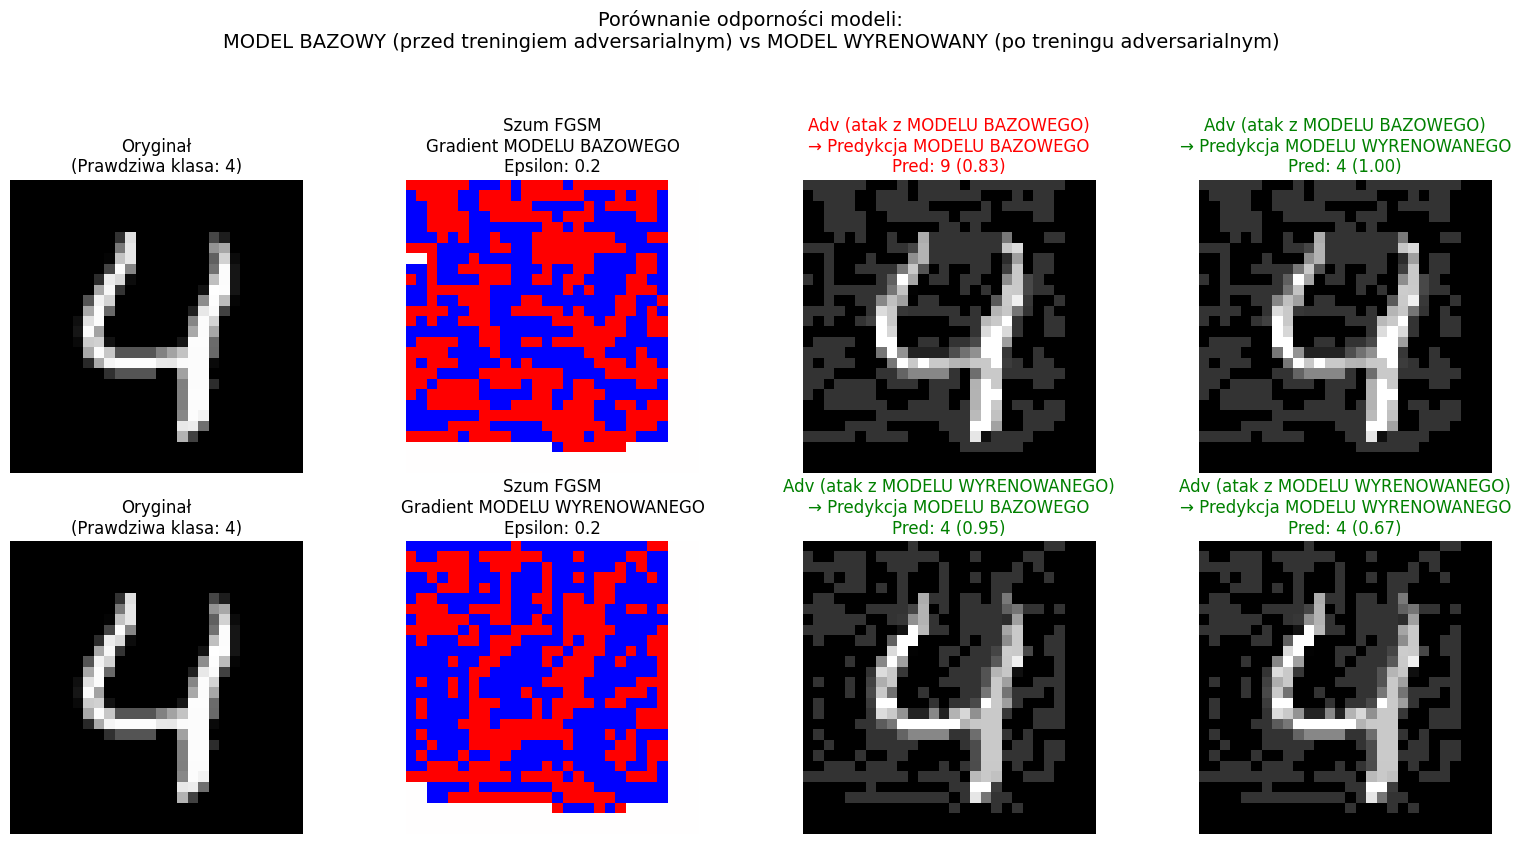

In [19]:
# === SZCZEGÓŁOWE PORÓWNANIE ATAKÓW ADVERSARIALNYCH (WIZUALIZACJA INSTANCJI) ===
# MODEL BAZOWY  -> przed treningiem adversarialnym
# MODEL WYRENOWANY -> po treningu adversarialnym

epsilon_viz = 0.2


def generate_adversarial_example(target_model, image, label, epsilon):
    """
    Generowanie przykładu adversarialnego FGSM dla konkretnego modelu
    """
    image_tensor = tf.convert_to_tensor(
        image.reshape((1, 28, 28, 1)), dtype=tf.float32
    )
    label_tensor = tf.convert_to_tensor(
        label.reshape((1, 10)), dtype=tf.float32
    )

    loss_object = tf.keras.losses.CategoricalCrossentropy()

    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        prediction = target_model(image_tensor)
        loss = loss_object(label_tensor, prediction)

    gradient = tape.gradient(loss, image_tensor)
    signed_grad = tf.sign(gradient)

    adv_image = image_tensor + epsilon * signed_grad
    adv_image = tf.clip_by_value(adv_image, 0, 1)

    return adv_image.numpy(), signed_grad.numpy()


# === WYBÓR PRÓBKI TESTOWEJ ===
idx = 4
sample_image = x_test[idx]
sample_label = y_test[idx]
true_class_idx = np.argmax(sample_label)

print(
    f"\n=== ANALIZA ADVERSARIALNA POJEDYNCZEJ PRÓBKI ===\n"
    f"Indeks obrazu: {idx}\n"
    f"Prawdziwa klasa: {true_class_idx}\n"
    f"Epsilon: {epsilon_viz}\n\n"
    f"MODEL BAZOWY      : przed treningiem adversarialnym\n"
    f"MODEL WYRENOWANY  : po treningu adversarialnym\n"
)

# === 1. ATAK WYGENEROWANY NA MODELU BAZOWYM (PRZED TRENINGIEM) ===
print("[1] Generowanie ataku FGSM na MODEL BAZOWY (przed treningiem adversarialnym)")
adv_base, noise_base = generate_adversarial_example(
    model, sample_image, sample_label, epsilon_viz
)

pred_base_on_adv_base = model.predict(adv_base, verbose=0)
pred_trained_on_adv_base = model_adv.predict(adv_base, verbose=0)

# === 2. ATAK WYGENEROWANY NA MODELU WYRENOWANYM (PO TRENINGU) ===
print("[2] Generowanie ataku FGSM na MODEL WYRENOWANY (po treningu adversarialnym)")
adv_trained, noise_trained = generate_adversarial_example(
    model_adv, sample_image, sample_label, epsilon_viz
)

pred_base_on_adv_trained = model.predict(adv_trained, verbose=0)
pred_trained_on_adv_trained = model_adv.predict(adv_trained, verbose=0)


# === WIZUALIZACJA ===
plt.figure(figsize=(16, 8))

# --- WIERSZ 1: ATAK Z MODELU BAZOWEGO ---
plt.subplot(2, 4, 1)
plt.title(f"Oryginał\n(Prawdziwa klasa: {true_class_idx})")
plt.imshow(sample_image.squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(2, 4, 2)
plt.title(f"Szum FGSM\nGradient MODELU BAZOWEGO\nEpsilon: {epsilon_viz}")
plt.imshow(noise_base.squeeze(), cmap="bwr", vmin=-1, vmax=1)
plt.axis("off")

plt.subplot(2, 4, 3)
pred_cls = np.argmax(pred_base_on_adv_base)
conf = np.max(pred_base_on_adv_base)
plt.title(
    f"Adv (atak z MODELU BAZOWEGO)\n"
    f"→ Predykcja MODELU BAZOWEGO\n"
    f"Pred: {pred_cls} ({conf:.2f})",
    color="red" if pred_cls != true_class_idx else "green",
)
plt.imshow(adv_base.squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(2, 4, 4)
pred_cls = np.argmax(pred_trained_on_adv_base)
conf = np.max(pred_trained_on_adv_base)
plt.title(
    f"Adv (atak z MODELU BAZOWEGO)\n"
    f"→ Predykcja MODELU WYRENOWANEGO\n"
    f"Pred: {pred_cls} ({conf:.2f})",
    color="red" if pred_cls != true_class_idx else "green",
)
plt.imshow(adv_base.squeeze(), cmap="gray")
plt.axis("off")

# --- WIERSZ 2: ATAK Z MODELU WYRENOWANEGO ---
plt.subplot(2, 4, 5)
plt.title(f"Oryginał\n(Prawdziwa klasa: {true_class_idx})")
plt.imshow(sample_image.squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(2, 4, 6)
plt.title(f"Szum FGSM\nGradient MODELU WYRENOWANEGO\nEpsilon: {epsilon_viz}")
plt.imshow(noise_trained.squeeze(), cmap="bwr", vmin=-1, vmax=1)
plt.axis("off")

plt.subplot(2, 4, 7)
pred_cls = np.argmax(pred_base_on_adv_trained)
conf = np.max(pred_base_on_adv_trained)
plt.title(
    f"Adv (atak z MODELU WYRENOWANEGO)\n"
    f"→ Predykcja MODELU BAZOWEGO\n"
    f"Pred: {pred_cls} ({conf:.2f})",
    color="red" if pred_cls != true_class_idx else "green",
)
plt.imshow(adv_trained.squeeze(), cmap="gray")
plt.axis("off")

plt.subplot(2, 4, 8)
pred_cls = np.argmax(pred_trained_on_adv_trained)
conf = np.max(pred_trained_on_adv_trained)
plt.title(
    f"Adv (atak z MODELU WYRENOWANEGO)\n"
    f"→ Predykcja MODELU WYRENOWANEGO\n"
    f"Pred: {pred_cls} ({conf:.2f})",
    color="red" if pred_cls != true_class_idx else "green",
)
plt.imshow(adv_trained.squeeze(), cmap="gray")
plt.axis("off")

plt.suptitle(
    "Porównanie odporności modeli:\n"
    "MODEL BAZOWY (przed treningiem adversarialnym) vs "
    "MODEL WYRENOWANY (po treningu adversarialnym)",
    fontsize=14,
    y=1.05,
)

plt.tight_layout()
plt.show()
